
# Transformer based distributed training

Transformer based distributed training - 50P - 50NP_exp_1.ipynb
50P- 50NP : Experiment 1


## Object Models: 15

1.	Bank
2.	Camping
3.	Canteen
4.	Customer_Order
5.	Ecommerce
6.	Hospital Management
7.	Library Management
8.	Onlinestore
9.	Student Course
10.	Traffic_Controller
11.	University
12.	Decider
13.	School_mgmt
14.	Store_mgmt
15. Credit Card Process


## Dataset Instances: 31139


## Total Training Data: 26470

### training set P :  14600

### training set NP : 11870


## Total Testing Data: 4670


### testing set P : 1440

### testing set NP : 3230

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization



In [2]:
## Using Mirrored Strategy for Distributed Training

In [3]:
# Enable mixed precision for better performance on GPUs with Tensor Cores
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Check the number of available GPUs
gpus = tf.config.list_physical_devices('GPU')
num_gpus = len(gpus)
if num_gpus > 1:
    # Enable mirrored strategy for distributed training
    strategy = tf.distribute.MirroredStrategy()
    print('Running distributed training on', num_gpus, 'GPUs.')
else:
    strategy = tf.distribute.get_strategy()
    print('Running training on a single GPU.')

Running training on a single GPU.


## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [4]:

!unzip new.zip

import pathlib

file_path = "/content/new.zip"
extracted_dir = pathlib.Path(file_path).parent
text_file = extracted_dir / "15_OM_60_final_1.txt"


Archive:  new.zip
  inflating: 15_OM_60_final_1.txt    


## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [5]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

Here's what our sentence pairs look like:

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

('module OM_name:0 ,openDeclarationtype one sig class1_name extends Class attr Set =c1_at1id=c1_at1 is Abstract = No no parent }type one sig c1_at1extendsc1_at1_type,type one sig class01_name extends Class attr Set =c01_at1id=c01_at1 is Abstract = No no parent }type one sig c01_at1extendsc01_at1_type,type one sig assoc1extendsAssociationsrc=class1_namedst=class01_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}type one sig class2_name extends Class attr Set =c2_at1id=c2_at1 is Abstract = No no parent }type one sig c2_at1extendsc2_at1_type,type one sig assoc2extendsAssociationsrc=class1_namedst=class2_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}type one sig class3_name extends Class attr Set =c3_at1+c3_at2id=c3_at1 is Abstract = No no parent }type one sig c3_at1extendsc3_at1_type one sig c3_at2extendsc3_at2_type,type one sig class4_name extends Class attr Set =c4_at1oneparentid=c3_at1 is Abstract = No parent in class3_name}type one sig c4_at1extendsc4_at1_type,type o

Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

26469 total pairs
18529 training pairs
3970 validation pairs
3970 test pairs


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [8]:
strip_chars = string.punctuation + ""
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 15000
sequence_length = 500
batch_size = 64


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [9]:

def format_dataset(eng, spa):
    eng = eng_vectorization(eng)
    spa = spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


# def make_dataset(pairs):
#     eng_texts, spa_texts = zip(*pairs)
#     eng_texts = list(eng_texts)
#     spa_texts = list(spa_texts)
#     dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.map(format_dataset)
#     return dataset.shuffle(2048).prefetch(16).cache()

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)

    # Distribute the dataset creation across multiple GPUs
    if num_gpus > 1:
        dataset = dataset.distribute(strategy)

    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()

# Create the datasets
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [10]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 500)
inputs["decoder_inputs"].shape: (64, 500)
targets.shape: (64, 500)


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [11]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "latent_dim": self.latent_dim,
            "num_heads": self.num_heads,
        })
        return config


Next, we assemble the end-to-end model.

In [12]:
embed_dim = 256
latent_dim = 2048
num_heads = 8


with strategy.scope():

  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
  x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
  encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
  encoder = keras.Model(encoder_inputs, encoder_outputs)

  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
  encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
  x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
  x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
  x = layers.Dropout(0.5)(x)
  decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
  decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

  decoder_outputs = decoder([decoder_inputs, encoder_outputs])
  transformer = keras.Model(
      [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
  )

## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [13]:
epochs = 120
  # This should be at least 30 for convergence
# steps_per_epoch = 100,
transformer.summary()
transformer.compile(
    "adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)



Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3968000     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   3155456     ['positional_embedding[

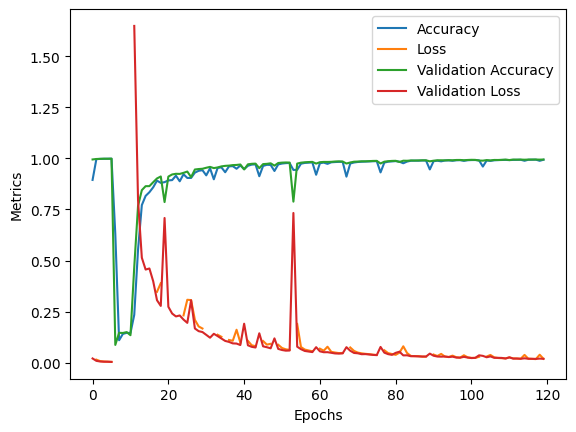

In [14]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [15]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 500


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

## Adding data from Test set

In [2]:
import pandas as pd


dc = pd.read_excel('random_set_1.0.xlsx')

In [3]:
dc.head()

,OM_Regular,OM_Prediction
0,"module OM_name:0 ,openDeclarationtype one sig ...",1
1,"module OM_name:0 ,openDeclarationtype one sig ...",1
2,"module OM_name:0 ,openDeclarationtype one sig ...",1
3,"module OM_name:0 ,openDeclarationtype one sig ...",1
4,"module OM_name:0 ,openDeclarationtype one sig ...",1


In [4]:
X_test2 = dc['OM_Regular'].values
y_test2 = dc['OM_Prediction'].values

In [5]:
print(X_test2.shape)
print(y_test2.shape)

print("X data type: ", X_test2.dtype)
print("y data type: ", y_test2.dtype)

(4669,)
(4669,)
X data type:  object
y data type:  int64


In [6]:
print(y_test2)

[1 1 1 ... 0 0 0]


In [7]:
inputs = X_test2

## Output from Unseen Data

In [8]:
# import time

# start_time = time.time()
# mylist_res = []
# for sentence in inputs:
#     result = decode_sequence(sentence)
#     mylist_res.append(result)
#     print(result)
#     time.sleep(1)  # Add a 1-second delay between each print statement

# end_time = time.time()
# execution_time = end_time - start_time

# print(f"Execution time: {execution_time} seconds")
# print(mylist_res)

## Result Computation

In [9]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [10]:
dd = pd.read_excel('random_set_1.0_pred.xlsx')

In [11]:
X_test_pred2 = dd['OM_Regular'].values
y_test_pred2 = dd['OM_Prediction'].values

In [12]:
print (y_test_pred2 )

[0 0 0 ... 1 1 1]


In [13]:
precision = precision_score(y_test2, y_test_pred2)
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test2, y_test_pred2)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test2, y_test_pred2)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test2, y_test_pred2))

Testing: Precision = 0.319826
Testing: Recall = 0.665969
Testing: F1 Score = 0.432127

Confusion Matrix (Test Data):
 [[1204 2031]
 [ 479  955]]


In [14]:
print(classification_report(y_test2,y_test_pred2))

              precision    recall  f1-score   support

           0       0.72      0.37      0.49      3235
           1       0.32      0.67      0.43      1434

    accuracy                           0.46      4669
   macro avg       0.52      0.52      0.46      4669
weighted avg       0.59      0.46      0.47      4669

